사람의 활동에 대한 팔과 다리의 움직임을 분석한 데이터로 활동-sitting 을 정상 데이터로, 활동 -jumping을 비정상 데이터로, 오토인코더 모델을 활용하여 이상치를 탐지하는 코드이다.

1. 기본 라이브러리 및 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Columns: 272 entries, T_xacc_mean to people
dtypes: float64(270), object(2)
memory usage: 18.9+ MB


In [4]:
class_act = df['activity'].unique()
class_act

array(['sitting', 'standing', 'lyingBack', 'lyingRigh', 'ascendingStairs',
       'decendingStairs', 'standingInElevatorStill', 'movingInElevator',
       'walkingLot', 'walkingTreadmillFlat', 'walkingTreadmillIncline',
       'runningTreadmill', 'stepper', 'crossTrainer', 'cyclingHorizontal',
       'cyclingVertical', 'rowing', 'jumping', 'basketBall'], dtype=object)

In [5]:
# 결측치 확인
df.isnull().values.any()

False

2. 전체 데이터셋에서 현재 작업에 필요한 활동인 sitting(normal) jumping(abnormal) 만 남기기

In [6]:
df = df[(df['activity']=='jumping') | (df['activity']=='sitting')]
# people 열 삭제
df = df.drop(['people'],axis=1)
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.18320,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.21290,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.21280,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.31700,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.25740,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,9.298029,32.4980,-6.0782,134.634624,11.603216,0.570723,-2.592341,1.73230,-12.91800,9.207424,...,9.303061e-04,0.030501,0.334449,0.625187,0.691300,0.571870,9.188517e-04,0.030313,0.274486,jumping
8636,8.738784,34.0480,-6.7822,145.225186,12.050941,0.760224,-2.417799,1.19030,-10.90200,9.233904,...,9.968638e-04,0.031573,0.396417,0.624749,0.693560,0.570400,9.632708e-04,0.031037,0.433661,jumping
8637,9.404261,34.8670,-5.3331,130.142955,11.408022,0.560963,-2.408945,0.81347,-8.21750,6.635468,...,9.194098e-04,0.030322,0.524964,0.631822,0.690120,0.581970,8.933477e-04,0.029889,0.335023,jumping
8638,9.139112,32.5060,-6.8835,135.812815,11.653876,0.589304,-2.359531,1.32350,-9.57930,7.510565,...,5.788992e-04,0.024060,0.301200,0.624196,0.688560,0.573620,1.025797e-03,0.032028,0.272121,jumping


데이터의 activity 열은 수치형 데이터가 아닌 Object 타입이 므로 수치형(범주형 데이터로 바꿔준다)

LabelEncoder를 사용할 수 도 있지만, 직접 map을 통하여 sitting 을 0, jumping을 1로 바꿀 수도 있다.

In [7]:
# 'sitting'을 0으로, 'jumping'을 1로 변환
df['activity'] = df['activity'].map({'sitting': 0, 'jumping': 1})
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.18320,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,0
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.21290,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,0
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.21280,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,0
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.31700,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,0
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.25740,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,9.298029,32.4980,-6.0782,134.634624,11.603216,0.570723,-2.592341,1.73230,-12.91800,9.207424,...,9.303061e-04,0.030501,0.334449,0.625187,0.691300,0.571870,9.188517e-04,0.030313,0.274486,1
8636,8.738784,34.0480,-6.7822,145.225186,12.050941,0.760224,-2.417799,1.19030,-10.90200,9.233904,...,9.968638e-04,0.031573,0.396417,0.624749,0.693560,0.570400,9.632708e-04,0.031037,0.433661,1
8637,9.404261,34.8670,-5.3331,130.142955,11.408022,0.560963,-2.408945,0.81347,-8.21750,6.635468,...,9.194098e-04,0.030322,0.524964,0.631822,0.690120,0.581970,8.933477e-04,0.029889,0.335023,1
8638,9.139112,32.5060,-6.8835,135.812815,11.653876,0.589304,-2.359531,1.32350,-9.57930,7.510565,...,5.788992e-04,0.024060,0.301200,0.624196,0.688560,0.573620,1.025797e-03,0.032028,0.272121,1


3. train / valid / test 로 데이터 셋 나누기 및 StandardScaler를 통한 데이터 표준화

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# train, test, valid
x_train, x_test = train_test_split(df,test_size=0.2)
x_train, x_valid = train_test_split(x_train, test_size=0.2)

# training/valid에서 jumping 데이터를 삭제 ( sitting 을 정상데이터로 사용)

x_train = x_train[x_train.activity == 0]
x_train=x_train.drop(['activity'],axis=1)

x_valid = x_valid[x_valid.activity ==0]
x_valid = x_valid.drop(['activity'],axis=1)

# 테스트 레이블을 남겨두는 이유는 나중에 정확도를 비교하기 위해서임

y_test = x_test['activity']

x_test = x_test.drop(['activity'],axis=1)

x_train.shape, x_valid.shape, x_test.shape

((297, 270), (83, 270), (192, 270))

In [37]:
# 표준화 하기. 표준화는 train에 fit한 결과를 바탕으로 나머지 valid,test에 적용해야한다.
ss=StandardScaler()
x_train=ss.fit_transform(x_train)
x_valid=ss.transform(x_valid)
x_test=ss.transform(x_test)

정상 비정상 클래스 비율 확인해보기 1:1 이다.

<ipython-input-10-18ebf4ee0311>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['activity'], sort = True)


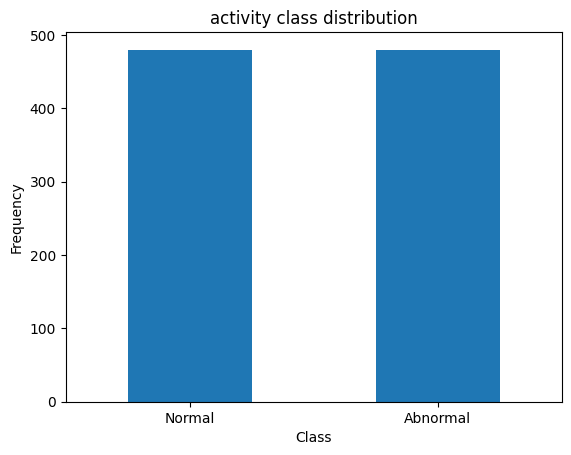

In [10]:
LABELS = ["Normal","Abnormal"]
count_classes = pd.value_counts(df['activity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("activity class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

4. 오토인코더 모델 정의 및 학습

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [52]:
# 오토인코더 모델

input_dim = x_train.shape[1]
#입력 차원의 1/10인 27을 넣을 수도 있다.
encoding_dim = 14  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 270)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 14)                  │           3,794 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 270)                 │           2,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,115 (23.89 KB)

 Trainable params: 6,115 (23.89 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = autoencoder.fit(x_train,x_train,epochs=50,batch_size=16,validation_data=(x_valid,x_valid),shuffle=True)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2661 - val_loss: 1.2386
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4761 - val_loss: 1.2145
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2280 - val_loss: 1.1629
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1522 - val_loss: 1.0829
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8712 - val_loss: 0.9992
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9550 - val_loss: 0.9452
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9207 - val_loss: 0.9165
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7751 - val_loss: 0.8997
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0679 - val_loss: 0.8865
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7912 - val_loss: 0.8768
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9767 - val_loss: 0.8686
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9862 - val_l

모델의 Loss 시각화하기

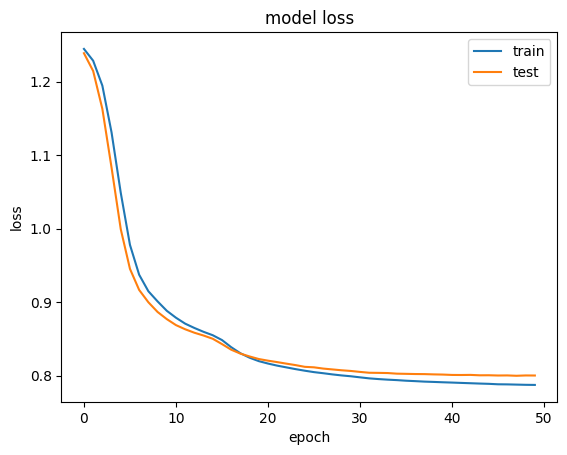

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

5. 최종 결과 및 분석

In [55]:
# X_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df = error_df.reset_index(drop = True)

error_df.describe()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,reconstruction_error,true_class
count,192.000000,192.000000
mean,0.934370,0.479167
std,0.632348,0.500872
min,0.472732,0.000000
25%,0.560085,0.000000
50%,0.649945,0.000000
75%,0.991130,1.000000
max,3.932621,1.000000


In [56]:
error_df.head()


,reconstruction_error,true_class
0,0.604150,0
1,1.063739,1
2,1.044622,1
3,0.528332,0
4,0.526018,0


정상 데이터의 Reconstruction Error 는 min 0.4, max 1.4 사이임을 알 수 있다.

In [57]:
error_df_normal = error_df[error_df['true_class'] == 0].reset_index(drop=True)

error_df_normal.describe()

,reconstruction_error,true_class
count,100.000000,100.0
mean,0.634455,0.0
std,0.188004,0.0
min,0.472732,0.0
25%,0.520153,0.0
50%,0.585345,0.0
75%,0.682223,0.0
max,1.490275,0.0


비정상 데이터의 Reconstruction Error 는 min 0.4 , max 3.9 사이임을 알 수 있다.

정상 데이터와 비교해보면 결과값이 유의미한 차이가 존재하지는 않아 분류하기 쉽지 않을 것이다.

In [58]:
error_df_abnormal = error_df[error_df['true_class'] == 1].reset_index(drop=True)

error_df_abnormal.describe()

,reconstruction_error,true_class
count,92.000000,92.0
mean,1.260364,1.0
std,0.771062,0.0
min,0.472739,1.0
25%,0.649021,1.0
50%,0.891997,1.0
75%,1.767099,1.0
max,3.932621,1.0


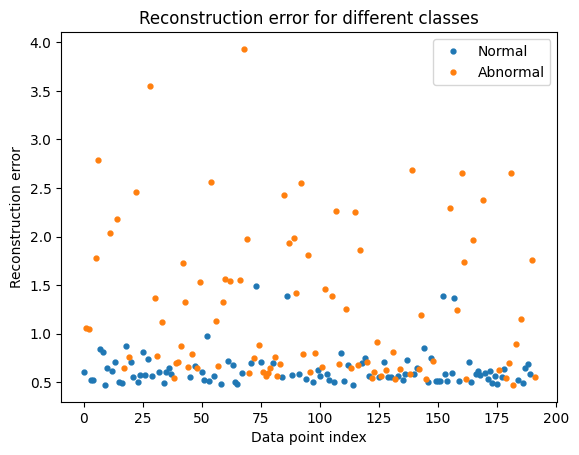

In [65]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

최적의 threshold를 찾아보는 과정 ROC Curve 사용

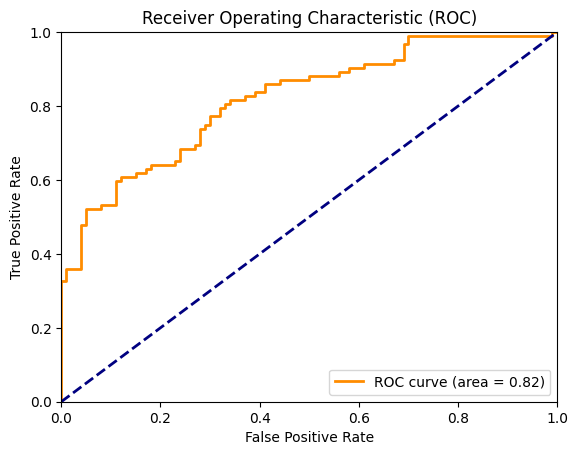

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 실제 클래스와 재구성 오류를 이용해 ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


최적의 파라미터 찾기

In [61]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")


Optimal Threshold: 0.7495629645881631


In [66]:
# threshold 값을 조정하여 최선의 정확도를 얻음,

threshold = 0.7495629645881631

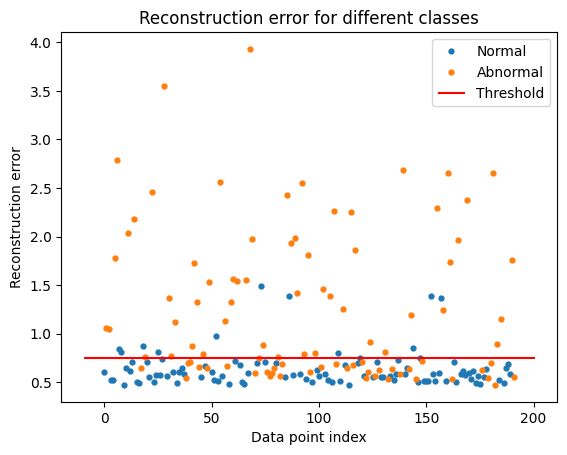

In [67]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

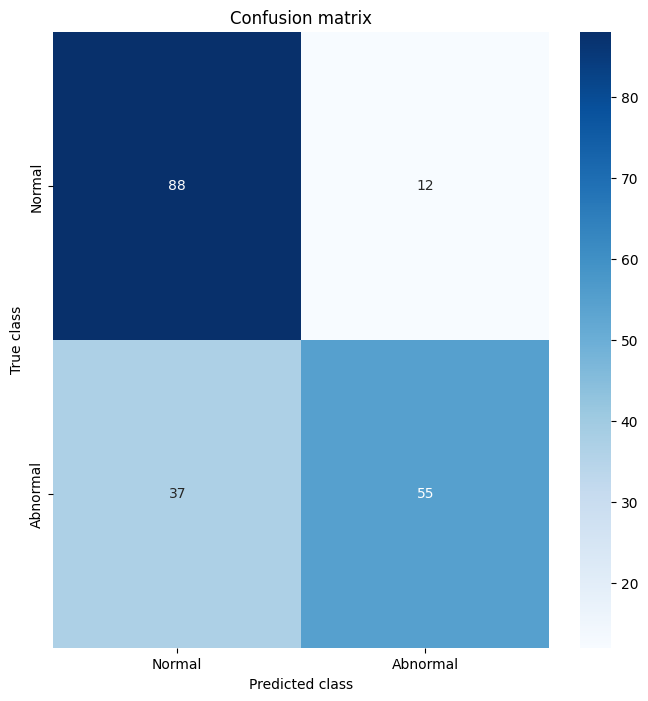

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       100
           1       0.82      0.60      0.69        92

    accuracy                           0.74       192
   macro avg       0.76      0.74      0.74       192
weighted avg       0.76      0.74      0.74       192



In [64]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))